In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
import sklearn.preprocessing as pr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
def create_gridcvs():
    #Initializing Classifiers
    clf1 = LogisticRegression(max_iter = 5000, solver = 'newton-cg')
    clf2 = KNeighborsClassifier()
    clf3 = tree.DecisionTreeClassifier()

    #Building the pipelines
    pipe1 = Pipeline([('std', StandardScaler()),
                      ('classifier', clf1)])

    pipe2 = Pipeline([('std', StandardScaler()),
                      ('classifier', clf2)])

    pipe3 = Pipeline([('std', StandardScaler()),
                      ('classifier', clf3)])

    #Setting up the parameter grids
    param_grid1 = [{'classifier__penalty': ['l1','l2'],
                   'classifier__C': np.power(10., np.arange(-8, 4))}]

    param_grid2 = [{'classifier__n_neighbors': [int(x) for x in np.logspace(0,2.7,num=25)]}]

    param_grid3 = [{'classifier__max_depth': [x for x in range(1,11)]}]

    # Setting up multiple GridSearchCV objects, 1 for each algorithm
    gridcvs = {}

    for pgrid, est, name in zip((param_grid1, param_grid2, param_grid3),
                               (pipe1, pipe2, pipe3),
                               ('Logistic', 'KNN', 'DecisionTree')):
        gcv = GridSearchCV(estimator=est,
                          param_grid = pgrid,
                          scoring = 'accuracy',
                          n_jobs = 4,
                          cv = 5,
                          verbose = 0,
                          refit = True)
        gridcvs[name] = gcv

    return gridcvs

# Dataset 1 (ADULT)

In [3]:
#Adult dataset.
adult = pd.read_csv('adult.data', index_col = False)#load data from file.
adult

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [4]:
le = LabelEncoder()

for col in adult:
    adult[col] = le.fit_transform(adult[col])

adult.head()

X = adult.drop([' <=50K'], axis = 1)
Y = adult[' <=50K']

print(X.shape)
print(Y.shape)

(32560, 14)
(32560,)


In [5]:
scores = {}
scores['Logistic'] = []
scores['KNN'] = []
scores['DecisionTree'] = []

## Trial 1

In [6]:
gridcvs = create_gridcvs()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    train_size = 5000,
                                                   random_state = 1234)

scaler = pr.MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(5000, 14)
(5000,)
(27560, 14)
(27560,)


In [8]:
%%time

cv_scores = {name: [] for name, gs_est in gridcvs.items()}

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

c = 1
for outer_train_idx, outer_valid_idx in skfold.split(X_train,y_train):
    for name, gs_est in sorted(gridcvs.items()):
        print('outer fold %d/5 | tuning %-8s' % (c, name), end='')

        # The inner loop for hyperparameter tuning
        gs_est.fit(X_train[outer_train_idx], y_train[outer_train_idx])
        y_pred = gs_est.predict(X_train[outer_valid_idx])
        acc = accuracy_score(y_true=y_train[outer_valid_idx], y_pred=y_pred)
        print(' | inner ACC %.2f%% | outer ACC %.2f%%' %
              (gs_est.best_score_ * 100, acc * 100))
        cv_scores[name].append(acc)

    c += 1

outer fold 1/5 | tuning DecisionTree | inner ACC 84.53% | outer ACC 84.50%
outer fold 1/5 | tuning KNN      | inner ACC 83.90% | outer ACC 82.80%
outer fold 1/5 | tuning Logistic | inner ACC 82.30% | outer ACC 81.90%
outer fold 2/5 | tuning DecisionTree | inner ACC 85.20% | outer ACC 83.80%
outer fold 2/5 | tuning KNN      | inner ACC 83.90% | outer ACC 81.90%
outer fold 2/5 | tuning Logistic | inner ACC 82.55% | outer ACC 81.20%
outer fold 3/5 | tuning DecisionTree | inner ACC 84.12% | outer ACC 85.50%
outer fold 3/5 | tuning KNN      | inner ACC 83.42% | outer ACC 84.20%
outer fold 3/5 | tuning Logistic | inner ACC 82.03% | outer ACC 82.80%
outer fold 4/5 | tuning DecisionTree | inner ACC 84.38% | outer ACC 84.90%
outer fold 4/5 | tuning KNN      | inner ACC 83.58% | outer ACC 84.30%
outer fold 4/5 | tuning Logistic | inner ACC 82.03% | outer ACC 83.40%
outer fold 5/5 | tuning DecisionTree | inner ACC 84.28% | outer ACC 83.60%
outer fold 5/5 | tuning KNN      | inner ACC 83.78% | out

In [9]:
for name in cv_scores:
    print('%-8s | outer CV acc. %.2f%% +\- %.3f' % (
          name, 100 * np.mean(cv_scores[name]), 100 * np.std(cv_scores[name])))
print()
for name in cv_scores:
    print('{} best parameters'.format(name), gridcvs[name].best_params_)

Logistic | outer CV acc. 82.40% +\- 0.767
KNN      | outer CV acc. 83.34% +\- 0.900
DecisionTree | outer CV acc. 84.46% +\- 0.700

Logistic best parameters {'classifier__C': 10.0, 'classifier__penalty': 'l2'}
KNN best parameters {'classifier__n_neighbors': 81}
DecisionTree best parameters {'classifier__max_depth': 5}


In [10]:
## get the respective test and training set errors for all algorithms 
##trial 1
trial1_err = {}
for name in gridcvs:
    clf = gridcvs[name].best_estimator_
    clf.fit(X_train, y_train)
    print('Optimal Training Performance for {}: {:.2f}%'.format(name, clf.score(X_train, y_train)*100))
    print('Optimal Test Performance for {}: {:.2f}%'.format(name, clf.score(X_test, y_test)*100))
    print()
    trial1_err[name] = np.array((clf.score(X_train, y_train), clf.score(X_test, y_test)))
    scores[name].append(clf.score(X_test, y_test))
    
trial1_err

Optimal Training Performance for Logistic: 82.42%
Optimal Test Performance for Logistic: 82.58%

Optimal Training Performance for KNN: 83.80%
Optimal Test Performance for KNN: 83.51%

Optimal Training Performance for DecisionTree: 85.02%
Optimal Test Performance for DecisionTree: 84.52%



{'Logistic': array([0.8242    , 0.82579826]),
 'KNN': array([0.838     , 0.83512337]),
 'DecisionTree': array([0.8502    , 0.84517417])}

## Trial 2

In [11]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Y, 
                                                    train_size = 5000,
                                                   random_state = 123)

scaler = pr.MinMaxScaler()

X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)
y_train2 = y_train2.to_numpy()
y_test2 = y_test2.to_numpy()

print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(5000, 14)
(5000,)
(27560, 14)
(27560,)


In [12]:
%%time

cv_scores = {name: [] for name, gs_est in gridcvs.items()}

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

c = 1
for outer_train_idx, outer_valid_idx in skfold.split(X_train2,y_train2):
    for name, gs_est in sorted(gridcvs.items()):
        print('outer fold %d/5 | tuning %-8s' % (c, name), end='')

        # The inner loop for hyperparameter tuning
        gs_est.fit(X_train2[outer_train_idx], y_train2[outer_train_idx])
        y_pred = gs_est.predict(X_train2[outer_valid_idx])
        acc = accuracy_score(y_true=y_train2[outer_valid_idx], y_pred=y_pred)
        print(' | inner ACC %.2f%% | outer ACC %.2f%%' %
              (gs_est.best_score_ * 100, acc * 100))
        cv_scores[name].append(acc)

    c += 1

outer fold 1/5 | tuning DecisionTree | inner ACC 85.20% | outer ACC 85.60%
outer fold 1/5 | tuning KNN      | inner ACC 83.15% | outer ACC 83.80%
outer fold 1/5 | tuning Logistic | inner ACC 81.88% | outer ACC 82.70%
outer fold 2/5 | tuning DecisionTree | inner ACC 85.25% | outer ACC 85.80%
outer fold 2/5 | tuning KNN      | inner ACC 83.38% | outer ACC 83.80%
outer fold 2/5 | tuning Logistic | inner ACC 81.75% | outer ACC 82.30%
outer fold 3/5 | tuning DecisionTree | inner ACC 85.38% | outer ACC 84.80%
outer fold 3/5 | tuning KNN      | inner ACC 83.70% | outer ACC 81.90%
outer fold 3/5 | tuning Logistic | inner ACC 82.20% | outer ACC 81.10%
outer fold 4/5 | tuning DecisionTree | inner ACC 84.55% | outer ACC 86.90%
outer fold 4/5 | tuning KNN      | inner ACC 82.90% | outer ACC 83.90%
outer fold 4/5 | tuning Logistic | inner ACC 81.33% | outer ACC 83.40%
outer fold 5/5 | tuning DecisionTree | inner ACC 84.92% | outer ACC 84.70%
outer fold 5/5 | tuning KNN      | inner ACC 83.95% | out

In [13]:
for name in cv_scores:
    print('%-8s | outer CV acc. %.2f%% +\- %.3f' % (
          name, 100 * np.mean(cv_scores[name]), 100 * np.std(cv_scores[name])))
print()
for name in cv_scores:
    print('{} best parameters'.format(name), gridcvs[name].best_params_)

Logistic | outer CV acc. 81.92% +\- 1.177
KNN      | outer CV acc. 82.94% +\- 1.111
DecisionTree | outer CV acc. 85.56% +\- 0.796

Logistic best parameters {'classifier__C': 0.01, 'classifier__penalty': 'l2'}
KNN best parameters {'classifier__n_neighbors': 177}
DecisionTree best parameters {'classifier__max_depth': 5}


In [14]:
trial2_err = {}
for name in gridcvs:
    clf = gridcvs[name].best_estimator_
    clf.fit(X_train2, y_train2)
    print('Optimal Training Performance for {}: {:.2f}%'.format(name, clf.score(X_train2, y_train2)*100))
    print('Optimal Test Performance for {}: {:.2f}%'.format(name, clf.score(X_test2, y_test2)*100))
    print()
    trial2_err[name] = np.array((clf.score(X_train2, y_train2), clf.score(X_test2, y_test2)))
    scores[name].append(clf.score(X_test2, y_test2))
    
trial2_err

Optimal Training Performance for Logistic: 82.08%
Optimal Test Performance for Logistic: 82.46%

Optimal Training Performance for KNN: 83.52%
Optimal Test Performance for KNN: 83.43%

Optimal Training Performance for DecisionTree: 86.26%
Optimal Test Performance for DecisionTree: 85.14%



{'Logistic': array([0.8208    , 0.82463716]),
 'KNN': array([0.8352    , 0.83432511]),
 'DecisionTree': array([0.8626    , 0.85137881])}

## Trial 3

In [15]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, Y, 
                                                    train_size = 5000/X.shape[0],
                                                   random_state = 12)

scaler = pr.MinMaxScaler()

X_train3 = scaler.fit_transform(X_train3)
X_test3 = scaler.transform(X_test3)
y_train3 = y_train3.to_numpy()
y_test3 = y_test3.to_numpy()

print(X_train3.shape)
print(y_train3.shape)
print(X_test3.shape)
print(y_test3.shape)

(5000, 14)
(5000,)
(27560, 14)
(27560,)


In [16]:
%%time

cv_scores = {name: [] for name, gs_est in gridcvs.items()}

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

c = 1
for outer_train_idx, outer_valid_idx in skfold.split(X_train3,y_train3):
    for name, gs_est in sorted(gridcvs.items()):
        print('outer fold %d/5 | tuning %-8s' % (c, name), end='')

        # The inner loop for hyperparameter tuning
        gs_est.fit(X_train3[outer_train_idx], y_train3[outer_train_idx])
        y_pred = gs_est.predict(X_train3[outer_valid_idx])
        acc = accuracy_score(y_true=y_train3[outer_valid_idx], y_pred=y_pred)
        print(' | inner ACC %.2f%% | outer ACC %.2f%%' %
              (gs_est.best_score_ * 100, acc * 100))
        cv_scores[name].append(acc)

    c += 1

outer fold 1/5 | tuning DecisionTree | inner ACC 84.53% | outer ACC 84.70%
outer fold 1/5 | tuning KNN      | inner ACC 83.83% | outer ACC 81.40%
outer fold 1/5 | tuning Logistic | inner ACC 82.97% | outer ACC 81.10%
outer fold 2/5 | tuning DecisionTree | inner ACC 84.88% | outer ACC 84.30%
outer fold 2/5 | tuning KNN      | inner ACC 83.32% | outer ACC 83.70%
outer fold 2/5 | tuning Logistic | inner ACC 82.78% | outer ACC 82.00%
outer fold 3/5 | tuning DecisionTree | inner ACC 84.12% | outer ACC 85.10%
outer fold 3/5 | tuning KNN      | inner ACC 83.20% | outer ACC 83.30%
outer fold 3/5 | tuning Logistic | inner ACC 82.40% | outer ACC 82.50%
outer fold 4/5 | tuning DecisionTree | inner ACC 85.00% | outer ACC 84.00%
outer fold 4/5 | tuning KNN      | inner ACC 83.53% | outer ACC 82.50%
outer fold 4/5 | tuning Logistic | inner ACC 82.60% | outer ACC 83.00%
outer fold 5/5 | tuning DecisionTree | inner ACC 84.73% | outer ACC 85.30%
outer fold 5/5 | tuning KNN      | inner ACC 83.10% | out

In [17]:
for name in cv_scores:
    print('%-8s | outer CV acc. %.2f%% +\- %.3f' % (
          name, 100 * np.mean(cv_scores[name]), 100 * np.std(cv_scores[name])))
print()
for name in cv_scores:
    print('{} best parameters'.format(name), gridcvs[name].best_params_)

Logistic | outer CV acc. 82.52% +\- 0.970
KNN      | outer CV acc. 83.06% +\- 1.033
DecisionTree | outer CV acc. 84.68% +\- 0.483

Logistic best parameters {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
KNN best parameters {'classifier__n_neighbors': 105}
DecisionTree best parameters {'classifier__max_depth': 6}


In [18]:
trial3_err = {}
for name in gridcvs:
    clf = gridcvs[name].best_estimator_
    clf.fit(X_train3, y_train3)
    print('Optimal Training Performance for {}: {:.2f}%'.format(name, clf.score(X_train3, y_train3)*100))
    print('Optimal Test Performance for {}: {:.2f}%'.format(name, clf.score(X_test3, y_test3)*100))
    print()
    trial3_err[name] = np.array((clf.score(X_train3, y_train3), clf.score(X_test3, y_test3)))
    scores[name].append(clf.score(X_test3, y_test3))
    
trial3_err
          

Optimal Training Performance for Logistic: 82.82%
Optimal Test Performance for Logistic: 82.33%

Optimal Training Performance for KNN: 83.62%
Optimal Test Performance for KNN: 83.29%

Optimal Training Performance for DecisionTree: 85.78%
Optimal Test Performance for DecisionTree: 85.09%



{'Logistic': array([0.8282    , 0.82325835]),
 'KNN': array([0.8362    , 0.83287373]),
 'DecisionTree': array([0.8578   , 0.8509434])}

## Results

In [19]:
print(trial1_err)
print(trial2_err)
print(trial3_err)


{'Logistic': array([0.8242    , 0.82579826]), 'KNN': array([0.838     , 0.83512337]), 'DecisionTree': array([0.8502    , 0.84517417])}
{'Logistic': array([0.8208    , 0.82463716]), 'KNN': array([0.8352    , 0.83432511]), 'DecisionTree': array([0.8626    , 0.85137881])}
{'Logistic': array([0.8282    , 0.82325835]), 'KNN': array([0.8362    , 0.83287373]), 'DecisionTree': array([0.8578   , 0.8509434])}


In [20]:
avg_trial_err = {}
for name in trial1_err:
    avg_trial_err[name] = np.array((trial1_err[name] + 
                          trial2_err[name] +
                          trial3_err[name])/3.)

for name in avg_trial_err:
    print("Mean training set performance for Adult dataset for {} algorithm: {:.5f}%".format(name, avg_trial_err[name][0]*100))
    print("Mean test set performance for Adult dataset for {} algorithm: {:.5f}%".format(name, avg_trial_err[name][1]*100))
    print()

Mean training set performance for Adult dataset for Logistic algorithm: 82.44000%
Mean test set performance for Adult dataset for Logistic algorithm: 82.45646%

Mean training set performance for Adult dataset for KNN algorithm: 83.64667%
Mean test set performance for Adult dataset for KNN algorithm: 83.41074%

Mean training set performance for Adult dataset for DecisionTree algorithm: 85.68667%
Mean test set performance for Adult dataset for DecisionTree algorithm: 84.91655%



In [21]:
avg_trial = pd.DataFrame.from_dict(avg_trial_err)
avg_trial['Set'] = ['Train', 'Test']
avg_trial = avg_trial.reindex(columns = ['Set', 'Logistic', 'KNN', 'DecisionTree'])
avg_trial

,Set,Logistic,KNN,DecisionTree
0,Train,0.824400,0.836467,0.856867
1,Test,0.824565,0.834107,0.849165


In [22]:
avg_trial.to_csv(r'Adult_Machine_Learning.csv', index = False, header = True)

In [23]:
adult_scores = pd.DataFrame.from_dict(scores)
adult_scores = adult_scores.reindex(columns = ['Logistic','KNN','DecisionTree'])
adult_scores

,Logistic,KNN,DecisionTree
0,0.825798,0.835123,0.845174
1,0.824637,0.834325,0.851379
2,0.823258,0.832874,0.850943


In [24]:
adult_scores.to_csv(r'adult_scores.csv', index = False, header = True)

## Visualization

### Heatmaps

In [25]:
import seaborn as sns

In [39]:
# Draw heatmaps for result of grid search.
def draw_heatmap(errors, D_list, ylabel, name, title):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(errors, annot=False, fmt='.3f', yticklabels=D_list, xticklabels=[])
    ax.collections[0].colorbar.set_label('error')
    ax.set(ylabel= ylabel)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title(title)
    plt.savefig('{}.jpg'.format(name))
    plt.show()

In [40]:
d_list = [x for x in range(1,11)]
n_list = [int(x) for x in np.logspace(0,2.7,num=25)]
l_list = np.power(10., np.arange(-8, 4))

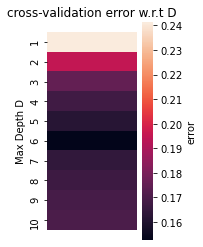

In [41]:
error = 1 - gridcvs['DecisionTree'].cv_results_['mean_test_score']
cross_val_score = np.reshape(error, (len(error), 1))
draw_heatmap(cross_val_score, d_list, "Max Depth D", 'DecisionTree Heatmap ADULT Dataset',title='cross-validation error w.r.t D')

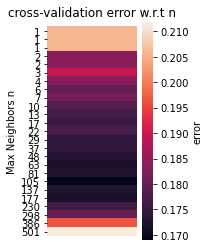

In [42]:
error = 1 - gridcvs['KNN'].cv_results_['mean_test_score']
cross_val_score = np.reshape(error, (len(error), 1))
draw_heatmap(cross_val_score, n_list, "Max Neighbors n", 'KNN Heatmap ADULT Dataset',title='cross-validation error w.r.t n')

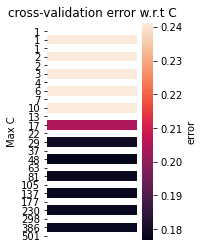

In [43]:
error = 1 - gridcvs['Logistic'].cv_results_['mean_test_score']
cross_val_score = np.reshape(error, (len(error), 1))
draw_heatmap(cross_val_score, n_list, "Max C", 'Logistic Heatmap ADULT Dataset',title='cross-validation error w.r.t C')

### Learning Curves

In [31]:
from sklearn.model_selection import learning_curve

In [32]:
def plot(train_sizes, train_scores, test_scores, name):
    # Creating means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    
    # Creating means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Drawing lines
    plt.subplots(1, figsize=(10,10))
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")
    
    # Drawing bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
    
    # Creating plot
    plt.title("Learning Curve for {}". format(name))
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.savefig('{}.jpg'.format(name))
    plt.show()
    

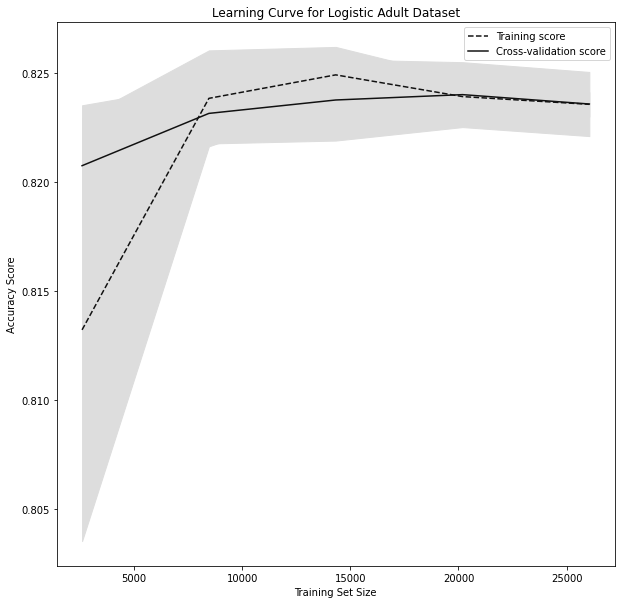

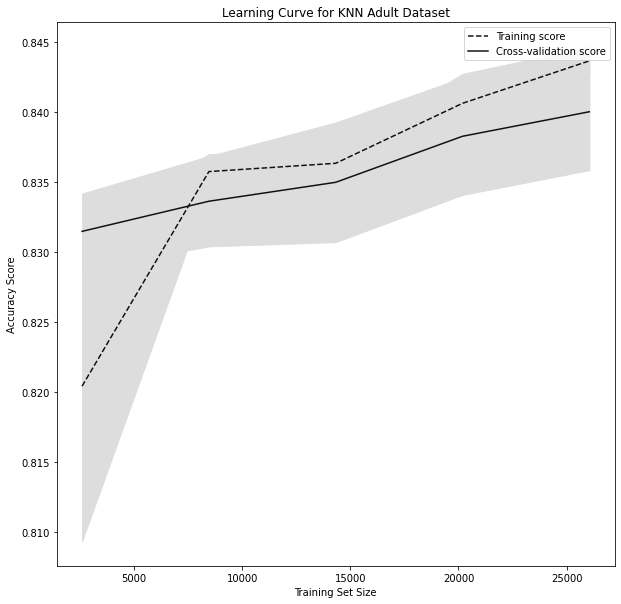

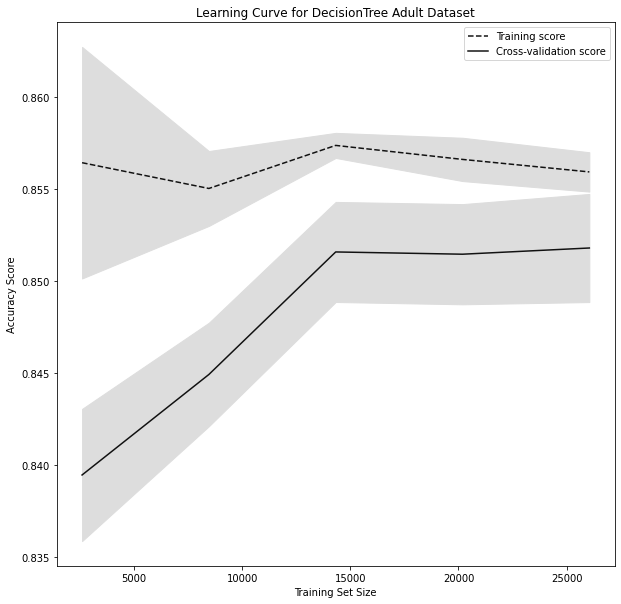

In [33]:
for name in gridcvs:
    train_size, train_score, test_score = learning_curve(gridcvs[name].best_estimator_,
                                                        X, Y,
                                                        cv = 5, n_jobs = 4,
                                                        scoring = 'accuracy')
    plot(train_size, train_score, test_score, name+' Adult Dataset')
    
    